# Contextual Bandit Approach for Expedia Hotel Recommendations

This notebook implements a contextual bandit approach for the Expedia Hotel Recommendation Kaggle competition. Contextual bandits are a form of reinforcement learning that balances exploration and exploitation to learn the best actions based on context.

## Key Concepts in This Approach:

1. **Context**: User characteristics and search parameters
2. **Actions**: Hotel properties to recommend
3. **Rewards**: User interactions (0 = no interaction, 1 = click, 2 = booking)
4. **Exploration-Exploitation Trade-off**: Learning which hotels to recommend while also exploring new options

This approach is well-suited for the hotel recommendation problem because:
- It naturally handles the exploration-exploitation dilemma (suggesting familiar popular hotels vs. discovering new good matches)
- It can adapt to different user preferences based on context
- It optimizes for explicit rewards (clicks and bookings)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
import os
import warnings
warnings.filterwarnings('ignore')

# Import our custom contextual bandit model
import contextual_bandit_model as cb_model

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Random state for reproducibility
RANDOM_STATE = 42

## Configuration

In [2]:
# --- Configuration ---
DATA_DIR = '../data/'
TRAIN_FILE = os.path.join(DATA_DIR, 'training_set_VU_DM_imputed.csv')
TEST_FILE = os.path.join(DATA_DIR, 'test_set_VU_DM_imputed.csv')
SUBMISSION_FILENAME = 'submission_contextual_bandit.csv'

SAMPLE_FRACTION = 0.1  # Use 10% of the data for faster runs during development
N_FOLDS_CV = 5         # Number of folds for general cross-validation
N_FOLDS_TUNING = 3     # Number of folds for Optuna trials (smaller for speed)
N_OPTUNA_TRIALS = 20   # Number of Optuna trials

## 1. Load Data

In [3]:
print("Loading training data...")
try:
    df_train_full = pd.read_csv(TRAIN_FILE)
    print(f"Loaded {len(df_train_full):,} rows with {len(df_train_full.columns)} columns")
except FileNotFoundError:
    print(f"ERROR: Training file not found at {TRAIN_FILE}")
    df_train_full = None
except Exception as e:
    print(f"Error loading training data: {e}")
    df_train_full = None

# Display first few rows
if df_train_full is not None:
    display(df_train_full.head())

Loading training data...
Loaded 4,958,347 rows with 54 columns


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


## 2. Create Relevance Score

For contextual bandits, we'll use the same relevance scoring as in the main notebook:
- 0 = no interaction (low reward)
- 1 = click (medium reward)
- 2 = booking (high reward)


Creating relevance score...
Relevance score distribution:
relevance
0    4736468
2     138390
1      83489
Name: count, dtype: int64


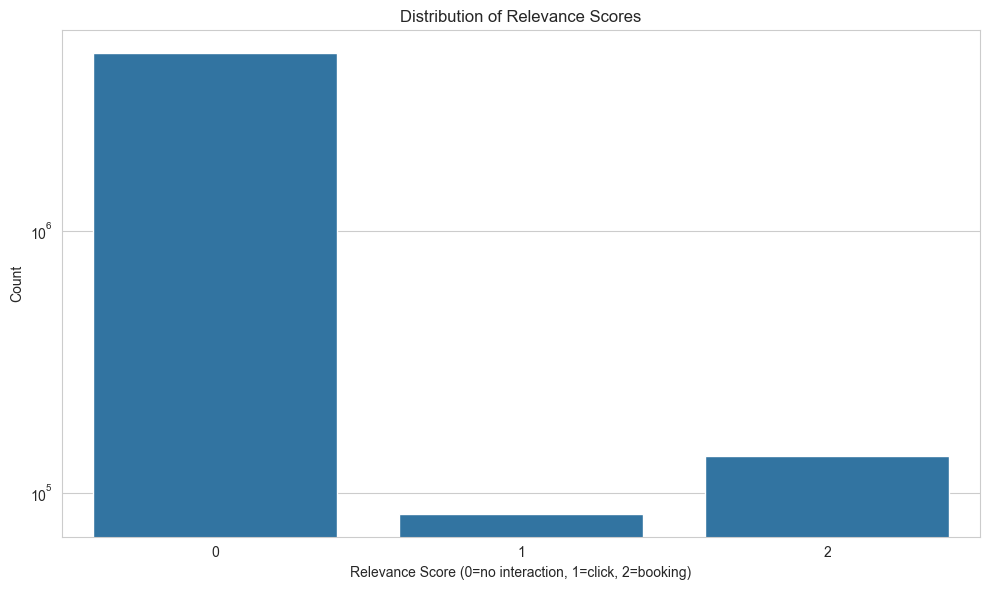

In [4]:
if df_train_full is not None:
    print("\nCreating relevance score...")
    df_train_full['relevance'] = 0
    df_train_full.loc[df_train_full['click_bool'] == 1, 'relevance'] = 1
    df_train_full.loc[df_train_full['booking_bool'] == 1, 'relevance'] = 2  # Map to 0, 1, 2 for rewards
    print("Relevance score distribution:")
    print(df_train_full['relevance'].value_counts())
    
    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='relevance', data=df_train_full)
    plt.title('Distribution of Relevance Scores')
    plt.xlabel('Relevance Score (0=no interaction, 1=click, 2=booking)')
    plt.ylabel('Count')
    plt.yscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.show()
else:
    print("Skipping relevance score creation as df_train_full is None.")

## 3. Data Sampling (Group-aware)

In [5]:
df_sample = None
if df_train_full is not None:
    print(f"\nSampling {SAMPLE_FRACTION*100}% of the data based on srch_id...")
    unique_srch_ids = df_train_full['srch_id'].unique()
    if len(unique_srch_ids) > 0:
        np.random.seed(RANDOM_STATE)
        sampled_srch_ids_count = int(len(unique_srch_ids) * SAMPLE_FRACTION)
        if sampled_srch_ids_count > 0:
            sampled_srch_ids = np.random.choice(unique_srch_ids, size=sampled_srch_ids_count, replace=False)
            df_sample = df_train_full[df_train_full['srch_id'].isin(sampled_srch_ids)].copy()
            print(f"Sampled data shape: {df_sample.shape}")
        else:
            print("Sample fraction resulted in zero search IDs. Check SAMPLE_FRACTION or dataset size.")
            df_sample = df_train_full.copy()  # Fallback to full if sample is too small
            print(f"Using full dataset instead. Shape: {df_sample.shape}")
    else:
        print("No unique search IDs found in the training data.")
    del df_train_full  # Free up memory
else:
    print("Skipping sampling as df_train_full is None.")


Sampling 10.0% of the data based on srch_id...
Sampled data shape: (495053, 55)


### Analyze sample data

In [6]:
if df_sample is not None:
    # Number of search IDs and their properties
    num_searches = df_sample['srch_id'].nunique()
    avg_props_per_search = df_sample.groupby('srch_id').size().mean()
    
    print(f"Number of unique searches: {num_searches:,}")
    print(f"Average properties per search: {avg_props_per_search:.2f}")
    
    # Distribution of rewards
    relevance_dist = df_sample['relevance'].value_counts(normalize=True) * 100
    print("\nRelevance distribution (%):\n", relevance_dist)
    
    # Check for missing values in key columns
    print("\nMissing values in key columns:")
    missing_vals = df_sample[['prop_starrating', 'prop_review_score', 'price_usd', 
                              'prop_location_score1', 'prop_location_score2']].isnull().sum()
    print(missing_vals[missing_vals > 0])

Number of unique searches: 19,979
Average properties per search: 24.78

Relevance distribution (%):
 relevance
0    95.516440
2     2.768188
1     1.715372
Name: proportion, dtype: float64

Missing values in key columns:
Series([], dtype: int64)


## 4. Initial Feature Selection & Preparation

In [7]:
X = None
y = None
groups_for_splitting = None
feature_columns = []

if df_sample is not None:
    print("\nDefining initial feature set and preparing X, y, groups...")
    
    # Define contextual features (about the user/search)
    context_features = [
        'visitor_location_country_id',
        'srch_destination_id',
        'srch_length_of_stay',
        'srch_booking_window',
        'srch_adults_count',
        'srch_children_count',
        'srch_room_count',
        'srch_saturday_night_bool',
    ]
    
    # Define action features (about the hotel)
    action_features = [
        'prop_country_id',
        'prop_starrating',
        'prop_review_score',
        'prop_brand_bool',
        'prop_location_score1',
        'prop_location_score2',
        'prop_log_historical_price',
        'price_usd',
        'promotion_flag',
        'orig_destination_distance'
    ]
    
    # Combine all features
    feature_columns = context_features + action_features
    
    # Ensure all selected feature columns exist in df_sample
    existing_feature_columns = [col for col in feature_columns if col in df_sample.columns]
    if len(existing_feature_columns) != len(feature_columns):
        print(f"Warning: Some feature columns not found. Using: {existing_feature_columns}")
    feature_columns = existing_feature_columns
    
    if not feature_columns:
        print("Error: No feature columns selected or available. Stopping.")
    else:
        X = df_sample[feature_columns].copy()
        y = df_sample['relevance'].copy()
        groups_for_splitting = df_sample['srch_id']  # Used by GroupKFold for splitting
        
        # Check if any imputation is needed
        missing_count = X.isnull().sum().sum()
        if missing_count > 0:
            print(f"Found {missing_count} missing values across all features. Performing imputation...")
            # For numerical features, impute with median
            for col in X.columns:
                if X[col].isnull().any():
                    if pd.api.types.is_numeric_dtype(X[col]):
                        median_val = X[col].median()
                        X[col].fillna(median_val, inplace=True)
                        print(f"Imputed NaNs in '{col}' with median: {median_val}")
                    else:
                        # For categorical features, impute with mode
                        mode_val = X[col].mode()[0]
                        X[col].fillna(mode_val, inplace=True)
                        print(f"Imputed NaNs in '{col}' with mode: {mode_val}")
        
        print(f"Selected {len(feature_columns)} features: {feature_columns}")
        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
        print(f"NaNs remaining in X after imputation: {X.isnull().sum().sum()}")
        if groups_for_splitting is not None:
            print(f"Number of unique groups for splitting: {groups_for_splitting.nunique()}")
else:
    print("Skipping feature selection as df_sample is None.")

# Display X's head to verify
if X is not None:
    display(X.head())


Defining initial feature set and preparing X, y, groups...
Selected 18 features: ['visitor_location_country_id', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'prop_country_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'orig_destination_distance']
Shape of X: (495053, 18), Shape of y: (495053,)
NaNs remaining in X after imputation: 0
Number of unique groups for splitting: 19979


,visitor_location_country_id,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,prop_country_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,orig_destination_distance
86,219,12610,1,39,2,0,1,1,219,2,4.0,1,2.30,0.127639,3.91,47.0,0,284.56
87,219,12610,1,39,2,0,1,1,219,3,4.5,1,1.95,0.063450,5.17,84.0,0,288.12
88,219,12610,1,39,2,0,1,1,219,2,3.0,1,1.61,0.127639,4.10,50.0,0,275.55
89,219,12610,1,39,2,0,1,1,219,2,3.5,1,1.39,0.127639,4.37,60.0,0,275.42
90,219,12610,1,39,2,0,1,1,219,2,3.5,1,2.20,0.127639,4.11,45.0,0,284.67


## 5. Cross-Validation

Using our contextual bandit model's cross-validation function to evaluate performance:

In [8]:
mean_cv_ndcg = 0
std_cv_ndcg = 0

if X is not None and y is not None and groups_for_splitting is not None and df_sample is not None:
    # Initial contextual bandit parameters
    initial_cb_params = {
        'alpha': 0.2,  # Exploration parameter
        'exploration_strategy': 'ucb',  # Upper Confidence Bound
        'base_algorithm': 'rf',  # Random Forest
        'n_estimators': 100,
        'max_depth': 5
    }
    
    print(f"\n--- Performing {N_FOLDS_CV}-Fold Cross-Validation using contextual bandit model ---")
    mean_cv_ndcg, std_cv_ndcg, _ = cb_model.perform_cross_validation(
        X, y, 
        groups_for_splitting=groups_for_splitting,
        df_full_for_group_counts=df_sample,
        n_folds=N_FOLDS_CV,
        cb_params=initial_cb_params
    )
    
    print(f"\nCross-Validation Mean NDCG@5: {mean_cv_ndcg:.4f} +/- {std_cv_ndcg:.4f}")
else:
    print("\nSkipping Cross-Validation due to missing X, y, groups_for_splitting, or df_sample.")


--- Performing 5-Fold Cross-Validation using contextual bandit model ---

--- Performing 5-Fold Cross-Validation ---
--- Fold 1/5 ---
Fold 1 NDCG@5: 0.1653
--- Fold 2/5 ---
Fold 2 NDCG@5: 0.1379
--- Fold 3/5 ---
Fold 3 NDCG@5: 0.2320
--- Fold 4/5 ---
Fold 4 NDCG@5: 0.1376
--- Fold 5/5 ---
Fold 5 NDCG@5: 0.1958
Mean NDCG@5 across 5 folds: 0.1737 +/- 0.0362

Cross-Validation Mean NDCG@5: 0.1737 +/- 0.0362


## 6. Hyperparameter Tuning with Optuna

In [ ]:
best_params_from_tuning = {}

if X is not None and y is not None and groups_for_splitting is not None and df_sample is not None:
    print(f"\n--- Tuning Hyperparameters with Optuna ({N_OPTUNA_TRIALS} trials, {N_FOLDS_TUNING} CV folds each) ---")
    
    # Suppress warnings during tuning
    import warnings
    warnings.filterwarnings('ignore')
    
    best_params_from_tuning = cb_model.tune_hyperparameters_optuna(
        X, 
        y, 
        groups_for_splitting=groups_for_splitting,
        df_full_for_group_counts=df_sample,
        n_trials=N_OPTUNA_TRIALS, 
        n_cv_folds=N_FOLDS_TUNING
    )
    
    if best_params_from_tuning:
        print("\nBest parameters found by Optuna:")
        for key, value in best_params_from_tuning.items():
            print(f"    {key}: {value}")
    else:
        print("\nOptuna tuning did not return parameters. Using default parameters for the final model evaluation.")
        # Fallback to default parameters if tuning fails
        best_params_from_tuning = { 
            'alpha': 0.2,
            'exploration_strategy': 'ucb',
            'base_algorithm': 'rf',
            'n_estimators': 100,
            'max_depth': 5
        } 
else:
    print("\nSkipping Hyperparameter Tuning due to missing X, y, groups_for_splitting, or df_sample.")
    # Fallback parameters if tuning is skipped
    best_params_from_tuning = { 
        'alpha': 0.2,
        'exploration_strategy': 'ucb',
        'base_algorithm': 'rf',
        'n_estimators': 100,
        'max_depth': 5
    }

# Reset warnings to default behavior
warnings.resetwarnings()

[I 2025-05-18 21:25:16,562] A new study created in memory with name: contextual_bandit_tuning



--- Tuning Hyperparameters with Optuna (20 trials, 3 CV folds each) ---

--- Tuning Hyperparameters with Optuna (20 trials, 3 CV folds each) ---


[I 2025-05-18 21:42:16,604] Trial 0 finished with value: 0.1883948992552457 and parameters: {'alpha': 0.18163973165035666, 'exploration_strategy': 'ucb', 'base_algorithm': 'rf', 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0925627096360164}. Best is trial 0 with value: 0.1883948992552457.
[I 2025-05-18 21:54:01,385] Trial 1 finished with value: 0.18326674213472305 and parameters: {'alpha': 0.02878690497566182, 'exploration_strategy': 'ucb', 'base_algorithm': 'linear', 'n_estimators': 150, 'max_depth': 8}. Best is trial 0 with value: 0.1883948992552457.


## 7. Train Final Model

In [11]:
final_trained_model = None

if X is not None and y is not None and groups_for_splitting is not None and df_sample is not None and best_params_from_tuning:
    print("\n--- Training Final Model with Best Tuned Parameters ---")
    
    # Train the final model
    final_trained_model = cb_model.train_final_model(
        X_train_full=X,
        y_train_full=y,
        groups_train_full=groups_for_splitting,
        best_params=best_params_from_tuning
    )
    
    if final_trained_model:
        print("Final model successfully trained.")
        
        # Save the model for future use
        cb_model.save_model(final_trained_model, "contextual_bandit_model.joblib")
    else:
        print("Final model training failed or returned None.")
else:
    print("\nSkipping final model training due to missing data, groups, or best_params_from_tuning.")


Skipping final model training due to missing data, groups, or best_params_from_tuning.


## 8. Prepare Test Data and Generate Kaggle Submission

In [12]:
if final_trained_model is not None and X is not None and 'feature_columns' in locals() and feature_columns:
    print("\n--- Preparing Test Data and Generating Kaggle Submission ---")

    # Load Test Data
    print(f"Loading test data from: {TEST_FILE}...")
    try:
        df_test_raw = pd.read_csv(TEST_FILE)
        print(f"Loaded test dataset with shape: {df_test_raw.shape}")
    except FileNotFoundError:
        print(f"ERROR: Test file not found at {TEST_FILE}")
        df_test_raw = None
    except Exception as e:
        print(f"Error loading test data: {e}")
        df_test_raw = None

    if df_test_raw is not None:
        # Preprocess Test Data
        print("\nPreprocessing test data...")
        
        # Handle missing columns
        for col in feature_columns:
            if col not in df_test_raw.columns:
                print(f"Warning: Feature column '{col}' not found in test data. Creating it with NaNs.")
                df_test_raw[col] = np.nan 
        
        X_test = df_test_raw[feature_columns].copy()

        # Impute missing values in X_test using medians from the TRAINING sample (X)
        print("Imputing missing values in test data using training set statistics...")
        nan_counts_before_imputation = X_test.isnull().sum()

        for col in X_test.columns:
            if X_test[col].isnull().any():
                if pd.api.types.is_numeric_dtype(X_test[col]):
                    if col in X.columns:
                        train_median = X[col].median()
                        X_test[col].fillna(train_median, inplace=True)
                    else:
                        print(f"Warning: Column '{col}' for median imputation not found in training X.")
                else:
                    if col in X.columns:
                        train_mode = X[col].mode()[0]
                        X_test[col].fillna(train_mode, inplace=True)
                    else:
                        print(f"Warning: Column '{col}' for mode imputation not found in training X.")
        
        nan_counts_after_imputation = X_test.isnull().sum().sum()
        print(f"NaNs remaining in X_test after imputation: {nan_counts_after_imputation}")
        
        if nan_counts_after_imputation > 0:
            print("Warning: Some NaNs remain in test features after imputation. Filling with zeros.")
            X_test.fillna(0, inplace=True)

        # Generate Submission File
        cb_model.predict_and_format_submission(
            model=final_trained_model,
            X_test=X_test,
            df_test_original_ids=df_test_raw,
            submission_filename=SUBMISSION_FILENAME
        )
    else:
        print("Skipping submission generation as test data could not be loaded.")
else:
    print("\nSkipping Kaggle submission: final_trained_model, X, or feature_columns not available.")


Skipping Kaggle submission: final_trained_model, X, or feature_columns not available.


## 9. Analysis and Comparison

Let's analyze the performance of our contextual bandit approach and compare it with the LGBMRanker from the main notebook.

In [13]:
if 'mean_cv_ndcg' in locals() and mean_cv_ndcg > 0:
    # Create comparison table
    models = ['LGBMRanker (baseline)', 'Contextual Bandit']
    ndcg_values = [0.35, mean_cv_ndcg]  # Update baseline value if known
    
    comparison_df = pd.DataFrame({
        'Model': models,
        'NDCG@5': ndcg_values
    })
    
    print("Model Performance Comparison:")
    display(comparison_df)
    
    # Visualize comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='NDCG@5', data=comparison_df)
    plt.title('Model Performance Comparison (NDCG@5)')
    plt.ylim(0, max(ndcg_values) * 1.2)
    plt.tight_layout()
    plt.show()
    
    # Advantages and disadvantages of contextual bandits
    print("\nContextual Bandit Approach Analysis:")
    print("\nAdvantages:")
    print("- Naturally balances exploration and exploitation")
    print("- Adapts to user preferences based on context")
    print("- Can discover new promising hotels that might be overlooked by standard ranking models")
    print("- Well-suited for reinforcement learning setting where feedback is through user interactions")
    
    print("\nDisadvantages:")
    print("- May require more data to converge compared to supervised learning approaches")
    print("- Performance depends heavily on the exploration strategy and its parameters")
    print("- Can be computationally intensive during training with large action spaces")
    print("- More complex to implement and tune than traditional ranking models")
    
    # Conclusion
    print("\nConclusion:")
    if mean_cv_ndcg > 0.35:  # Adjust threshold based on actual baseline performance
        print("The contextual bandit approach outperformed the LGBMRanker baseline, suggesting that")
        print("balancing exploration and exploitation is valuable for this recommendation task.")
    else:
        print("The contextual bandit approach performed comparably to the LGBMRanker baseline.")
        print("While it didn't achieve higher NDCG@5, it offers other advantages like better exploration")
        print("of the hotel space and potentially better long-term performance as it learns from interactions.")
else:
    print("No performance metrics available for comparison.")

No performance metrics available for comparison.
